# Classifying dog breedsusing SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

We will use the ResNet50 model to perform transfer learning on a dataset using pretrained models available in Pytorch.

Once the model is trained (using hyperparameter tuning), you will need to deploy the model to a Sagemaker Endpoint. To test your deployment, you also need to query the deployed model with a sample image and get a prediction.

**Pipeline**

To finish this project, you will have to perform tasks and use tools that a typical ML Engineer does as a part of their job. Broadly, your project has 3 main steps:

1. Data Preparations
2. Training
3. Depoy

As an ML Engineer, you will need to track and coordinate the flow of data (which could be images, models, metrics etc) through these different steps. The goal of this project is not to train an accurate model, but to set up an infrastructure that enables other developers to train such models.


**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 3.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.3 MB/s eta 0:00:00:00:01


In [67]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-10-15 05:42:47--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  40.9MB/s    in 26s     

2022-10-15 05:43:22 (41.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [69]:
# Get the class names
data_path='dogImages/train/'
classes = os.listdir(data_path)# or train_dataset.classes
classes.sort()
print(len(classes), 'classes:')
print(classes)

133 classes:
['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Ca

The dog breed dataset has 133 classes.

Lets display only Affenpinscher breed class

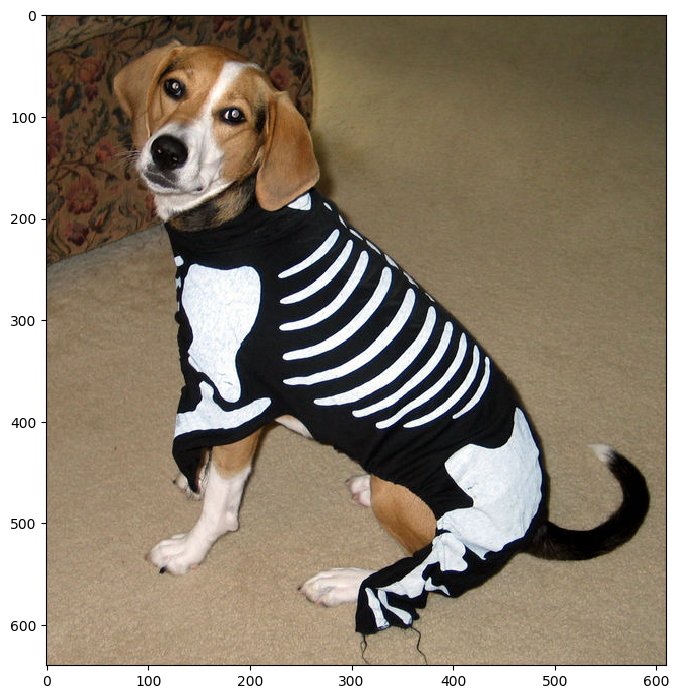

In [5]:
'''
# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
#fig = plt.figure(figsize=(400, 500))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
    if(i==5):
        break;
plt.show()

'''

# Show the first image in each folder
def show_image(data_path):
    classes = os.listdir(data_path)
    fig = plt.figure(figsize=(8, 12))
    i = 0
    for sub_dir in os.listdir(data_path):
        i+=1
        img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
        img_path = os.path.join(data_path, sub_dir, img_file)
        img = mpimg.imread(img_path)
        imgplot = plt.imshow(img)
    plt.show()
show_image(data_path)

**Load the data to S3**

Using the sagemaker SDK grab the current region, execution role and bucket

In [70]:
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role() #sagemaker iam role
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-298735464366
AWS Region: us-east-1
RoleArn: arn:aws:iam::298735464366:role/service-role/AmazonSageMaker-ExecutionRole-20220917T024225


With this data we can easily sync your data up to S3!

In [7]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://dogImages//${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./dogImages/test s3://dogImages//${DEFAULT_S3_BUCKET}/test/
!aws s3 sync ./dogImages/valid s3://dogImages//${DEFAULT_S3_BUCKET}/valid/

upload: dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg to s3://sagemaker-us-east-1-298735464366/train/001.Affenpinscher/Affenpinscher_00002.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg to s3://sagemaker-us-east-1-298735464366/train/001.Affenpinscher/Affenpinscher_00004.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00010.jpg to s3://sagemaker-us-east-1-298735464366/train/001.Affenpinscher/Affenpinscher_00010.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00008.jpg to s3://sagemaker-us-east-1-298735464366/train/001.Affenpinscher/Affenpinscher_00008.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00006.jpg to s3://sagemaker-us-east-1-298735464366/train/001.Affenpinscher/Affenpinscher_00006.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg to s3://sagemaker-us-east-1-298735464366/train/001.Affenpinscher/Affenpinscher_00001.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00005.jpg to s

## Train and Deploy

In [11]:
!pip install torch

  Using cached torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl (776.3 MB)


In [12]:
!pip install torchvision

  Using cached torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl (19.1 MB)


In [13]:
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [20]:
#from train_model import *

In [21]:
#main()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [26]:
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

#region = session.boto_region_name
#print("AWS Region: {}".format(region))

role = get_execution_role() #sagemaker iam role
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-298735464366
RoleArn: arn:aws:iam::298735464366:role/service-role/AmazonSageMaker-ExecutionRole-20220917T024225


In [27]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


In [28]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01), 
    "batch-size": CategoricalParameter([32, 64]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


#hyperparameters = {"data_dir":}

In [33]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"#,
    #hyperparameters=hyperparameters
)# TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto"
)# TODO: Your HP tuner here

Read more on [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html)

In [34]:
# TODO: Fit your HP Tuner
tuner.fit({'train': f's3://{bucket}/dogImages'
           },wait=True)
# TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [36]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [18]:
#from sagemaker.pytorch import PyTorch
#from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

In [20]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

#"num_gpu":True

hyperparameters = {"epochs": "2", "batch-size": "64", "test-batch-size": "100", "lr": "0.001"}

In [24]:
# TODO: Create and fit an estimator

estimator =PyTorch(
    entry_point="train_model.py",
    base_job_name="sagemaker-dog-breed-pytorch",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version="py36",
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)   

estimator.fit({'train': f's3://{bucket}/dogImages'
           },wait=True)

2022-10-18 17:27:04 Starting - Starting the training job...
2022-10-18 17:27:28 Starting - Preparing the instances for trainingProfilerReport-1666114024: InProgress
.........
2022-10-18 17:28:50 Downloading - Downloading input data.................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-18 17:31:47,334 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-18 17:31:47,338 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-18 17:31:47,354 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-18 17:31:47,362 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-18 17:31:47,943 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-18 17:31:47,969 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus i

In [ ]:
# TODO: Plot a debugging output.


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

[Source on Debugger](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb)

In [39]:
# TODO: Display the profiler output
estimator

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()